# ESGF Virtual Aggregation - Projected climate change signals and uncertainty under global warming levels

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products, which has been adapted to work with the ESGF Virtual Aggregation. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook is an **example of the calculation and visualization of the IPCC-WGI AR6 uncertainty methods (simple and advanced) for projected delta changes**. Please refer to the **AR6 WGI Cross-Chapter Box Atlas 1** ([Gutiérrez et al., 2021](https://www.ipcc.ch/report/ar6/wg1/chapter/atlas/)) for more information. We also **introduce the Global Warming Level dimension for the analysis of the climate change signal**.

This notebook works with data available in the ESGF, which is accessed in a **remote data access** fashion through virtual aggregations provided by the [ESGF Virtual Aggregation](https://doi.org/10.5194/gmd-2024-120).

In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## 1. The Global Warming Level analysis dimension

Instead of calculating climate change anomalies for a fixed period, we will calculate the anomaly for a given level of global warming (GWL). To do so, we need the information on the **time windows where the global surface temperature reaches the different levels of warming**. This information is available at the [IPCC-WGI/Atlas GitHub repository](https://github.com/IPCC-WG1/Atlas/tree/main/notebooks).

Note that we have pointed to the `CMIP6_Atlas_WarmingLevels.csv` file, as we are going to work with CMIP6 data. In this example, we will focus on the +3ºC GWL. We will consider the ssp585 scenario, however, any other scenario can be considered, as the anomalies do not vary significantly across scenarios when the GWL dimension is analyzed.

In [3]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv"
gwls_file = url.split("/")[-1]
with open(gwls_file, "w") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.text)
gwls = pd.read_csv(gwls_file)
model_runs = gwls["model_run"].str.split("_", expand=True).set_index(0)[1].to_dict()

## 2. Data loading for the different GWLs

To locate the data in which we are interested, we use the CSV inventory of the ESGF Virtual Aggregation. We will analyze the inventory using standard Pandas functionality. The data will be loaded in a remote data access fashion via OPeNDAP provided by a THREDDS Data Server.

The versions of the ESGF datasets in which we are interested are available in the `atlas-pr.csv' file provided in this same directory. These versions were extracted from the [IPCC-WGI/Atlas GitHub repository](https://raw.githack.com/IPCC-WG1/Atlas/devel/data-sources/CMIP6/CMIP6.html).

In [4]:
esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")
atlas_ipcc_catalog = pd.read_csv("atlas-pr.csv")

/tmp/ipykernel_759538/3620875463.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")


The following function manages the locations of the datasets from the ESGF Virtual Aggregation that we are interested in. Since some versions are no longer available on the ESGF—having been replaced by newer versions—not all of the original datasets will be loaded.

In [5]:
def find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, experiment):
    ignored_models = [
        "EC-Earth3-Veg", # replica unavailable
        "BCC-CSM2-MR", # time units change across netCDF files
        "KACE-1-0-G", # there is no ssp585 for this model
        "UKESM1-0-LL", # there is no ssp585 for this model
        "MIROC-ES2L", # no replica seems to work

        # not available later for Pangeo
        "ACCESS-CM2",
        "ACCESS-ESM1-5",

        # temporal removes
        "KIOST-ESM",
    ]
    
    preferred_replicas = {
        "historical": {
            "EC-Earth3-Veg": "esgf3.dkrz.de",
            "HadGEM3-GC31-LL": "", # esgf-data04.diasjp.net netcdf-java error, ...
        },
        "ssp585": {
            "EC-Earth3-Veg": "esgf3.dkrz.de",
            "HadGEM3-GC31-LL": "esgf-data1.llnl.gov",
        },
    }
    
    esgf_va_model_runs = []
    for model in model_runs:
        if model in ignored_models:
            continue
    
        esgf_va_subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == '{experiment}'").set_index(["project", "model", "experiment", "version"]).drop(["variable"], axis=1)
        atlas_ipcc_subset = atlas_ipcc_catalog.drop(["variable"], axis=1)
        
        subset = esgf_va_subset.join(atlas_ipcc_subset.set_index(["project", "model", "experiment", "version"]), on=["project", "model", "experiment", "version"], how="inner")
        if len(subset) > 0:
            # Choose the preferred replica or default to esgf.ceda.ac.uk
            if model in preferred_replicas[experiment]:
                replica = preferred_replicas[experiment][model]
            else:
                replica = "esgf.ceda.ac.uk"
    
            # Probe if the required model member is included in the esgf-va
            url = subset[subset["replica"] == replica]["location"].iloc[0]
            print(url)
            ds = xarray.open_dataset(
                url,
                decode_times=False,
                drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"])
    
            if model_runs[model].encode("ascii") in ds["variant_label"].values:
                record = {"url": url, "model_run": model + "_" + model_runs[model]}
                esgf_va_model_runs.append(record)

    return pd.DataFrame.from_records(esgf_va_model_runs)

Locate the datasets for both the historical and future scenario periods.

In [7]:
ssp585_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp585")
historical_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "historical")

https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_pr_gn_v20190529.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_pr_gn_v20191106.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_day_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_day_pr_gn_v20190429.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day_gn_v20200702/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_NCAR_CESM2-WACCM_ssp585_day_pr_gn_v20200702.ncml


/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_pr_gn_v20200622.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_pr_gr_v20190219.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_pr_gr_v20191202.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_pr_gr_v20191021.ncml
https://hub.ipcc.ifca.es/thredds/dod

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_gn_v20200616/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_pr_gn_v20200616.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_gr_v20180917/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_pr_gr_v20180917.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_pr_gr_v20191021.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_gr_v20181206/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_pr_gr_v20181206.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_EC-Eart

We now create a DataFrame containing all the available datasets.

In [8]:
df = historical_model_runs.set_index("model_run").join(
    ssp585_model_runs.set_index("model_run"), how="inner", lsuffix="h", rsuffix="s").rename(
    {"urlh": "historical", "urls": "ssp585"}, axis=1)
df

historical  \
model_run                                                                     
CAMS-CSM1-0_r2i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CanESM5_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CESM2-WACCM_r1i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CMCC-CM2-SR5_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-CM6-1_r1i1p1f2       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-CM6-1-HR_r1i1p1f2    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-ESM2-1_r1i1p1f2      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
EC-Earth3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
FGOALS-g3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
HadGEM3-GC31-LL_r1i1p1f3  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
IITM-ESM_r1i1p1f1         https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
IPSL-CM6A-LR_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
MPI-ESM1-2-HR_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
NorESM2-LM_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
TaiESM1_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   

                                                                     ssp585  
model_run                                                                    
CAMS-CSM1-0_r2i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CanESM5_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CESM2-WACCM_r1i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CMCC-CM2-SR5_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-CM6-1_r1i1p1f2       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-CM6-1-HR_r1i1p1f2    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-ESM2-1_r1i1p1f2      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
EC-Earth3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
FGOALS-g3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
HadGEM3-GC31-LL_r1i1p1f3  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
IITM-ESM_r1i1p1f1         https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
IPSL-CM6A-LR_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
MPI-ESM1-2-HR_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
NorESM2-LM_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
TaiESM1_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...

Open the datasets using [xarray](https://docs.xarray.dev/en/stable/).

In [9]:
def load_datasets(locations, members, experiment):
    dss = []
    for location in locations:
        name = location.split("/")[-1]
        model = name.split("_")[3]

        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
            variant_label=members[model].encode("ascii"))

        if experiment == "ssp585":
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

In [10]:
historical_dss = load_datasets(df["historical"], model_runs, "historical")
ssp585_dss = load_datasets(df["ssp585"], model_runs, "ssp585")

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/tmp/ipykernel_759538/3240490667.py:7: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Print size of the datasets:

In [17]:
for ds in historical_dss:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

11770.51 MB
1882.03 MB
12703.92 MB
12703.71 MB
7533.12 MB
59588.20 MB
7533.12 MB
30132.50 MB
3348.36 MB
6264.84 MB
4149.17 MB
4733.95 MB
16949.53 MB
3175.93 MB
12703.71 MB


In [18]:
for ds in ssp585_dss:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
1724.30 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


## 3. Data retrieval and subsetting

From the previous section, we observe that the datasets are relatively large, which would require substantial data transfer from the ESGF data nodes to the client executing the climate data analysis workflow. However, since we are focusing only on the European region, we can take advantage of remote data access subsetting capabilities to retrieve only the necessary data from the ESGF nodes to support the workflow.

To achieve this, we will implement a function responsible for efficiently fetching the required data.

In [11]:
def efficient_retrieval_and_compute(ds):
    lats, lons = slice(35, 72), slice(-11, 35) # Europe in (-180, 180)

    # handle Europe being split when using (0, 360)
    if ds["lon"].min().item() >= 0:
        left = ds.sel(lon=slice(0, 36), lat=lats).chunk({"time": 1000})
        right = ds.sel(lon=slice(348, 360), lat=lats).chunk({"time": 1000})

        spatial = xarray.concat([left, right], dim="lon")
    else:
        spatial = ds.sel(lon=lons, lat=lats)

    winter = spatial.sel(time=spatial.time.dt.month.isin([12,1,2])).resample({"time": "MS"}).sum().load()
    winter = winter.assign_coords(lon=((winter["lon"] + 180) % 360) - 180).sortby("lon")

    return winter

In [12]:
%%time

historical_dss_subset = [efficient_retrieval_and_compute(ds) for ds in historical_dss]

CPU times: user 5min 8s, sys: 1min 6s, total: 6min 14s
Wall time: 14min 52s


In [16]:
%%time

ssp585_dss_subset = [efficient_retrieval_and_compute(ds) for ds in ssp585_dss]

CPU times: user 2min 40s, sys: 32.6 s, total: 3min 13s
Wall time: 12min 7s


Now that we have loaded all the required data via subsetting and remote data access, we can examine the actual amount of data needed to carry out this workflow. We can observe that the data required to carry out the workflow is much smaller compared to the full size of the datasets.

In [17]:
for ds in historical_dss_subset:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

10.72 MB
1.67 MB
11.20 MB
11.19 MB
6.68 MB
54.22 MB
6.68 MB
27.62 MB
3.44 MB
5.66 MB
3.93 MB
4.16 MB
15.41 MB
2.87 MB
11.19 MB


In [18]:
for ds in ssp585_dss_subset:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

5.52 MB
0.87 MB
5.83 MB
5.83 MB
3.48 MB
28.26 MB
3.48 MB
14.40 MB
1.77 MB
2.95 MB
2.02 MB
2.17 MB
8.03 MB
1.50 MB
5.83 MB


## 4. Interpolation to a common grid

To perform the model agreement task, we need to interpolate to the same grid of the original Interactive Atlas dataset. We will obtain the grid from the original dataset.

In [19]:
iad_catalog = pd.read_csv("https://raw.githubusercontent.com/SantanderMetGroup/IPCC-Atlas-Datalab/refs/heads/main/data_inventory.csv")
iad_subset = iad_catalog.query('type == "opendap" & variable == "pr" & project == "CMIP6" & experiment == "ssp585" & frequency == "mon"')
iad_location = iad_subset["location"].iloc[0]
iad_location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc'

In [20]:
iad = xarray.open_dataset(iad_location).sel(lat=slice(35, 72), lon=slice(-11, 35))
iad["member"] = [b"_".join(member.split(b"_")[1:]).decode("ascii") for member in iad["member"].values]
iad["pr"]

<xarray.DataArray 'pr' (member: 33, time: 1032, lat: 37, lon: 46)> Size: 232MB
[57963312 values with dtype=float32]
Coordinates:
  * member   (member) <U24 3kB 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
  * time     (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2100-12-01
  * lat      (lat) float64 296B 35.5 36.5 37.5 38.5 39.5 ... 68.5 69.5 70.5 71.5
  * lon      (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 31.5 32.5 33.5 34.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    units:          mm
    cell_methods:   time: sum within days time: mean over days area: mean
    long_name:      Monthly mean of daily accumulated precipitation
    comment:        Monthly mean of daily accumulated precipitation of liquid...
    grid_mapping:   crs
    _ChunkSizes:    [  1   1 180 360]

Once we have got access to the Interactive Atlas dataset, we perform interpolation.

In [21]:
ssp585_dss_subset_interp = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in ssp585_dss_subset]

historical_dss_subset_interp = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in historical_dss_subset]

In [22]:
for ds in ssp585_dss_subset_interp:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

for ds in historical_dss_subset_interp:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

In [23]:
cmip6_ssp585 = xarray.concat(
    ssp585_dss_subset_interp,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in ssp585_dss_subset_interp]))

cmip6_historical = xarray.concat(
    historical_dss_subset_interp,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in historical_dss_subset_interp]))

## 5. Global warming levels

Since we are working with warming levels and need to load a different period of years for each model, we will first extract the information about the members from the inventory. This information is essential to match the GWL array obtained earlier. In other words, we need to create an index object that provides the model position in the data for each row in the gwl3 object. 

In [24]:
gwls3 = gwls[["model_run", "3_ssp585"]]
model_run_gwl = df.join(gwls3.set_index("model_run"), on="model_run")["3_ssp585"]
model_run_gwl

model_run
CAMS-CSM1-0_r2i1p1f1        2088
CanESM5_r1i1p1f1            2040
CESM2-WACCM_r1i1p1f1        2053
CMCC-CM2-SR5_r1i1p1f1       2052
CNRM-CM6-1_r1i1p1f2         2058
CNRM-CM6-1-HR_r1i1p1f2      2051
CNRM-ESM2-1_r1i1p1f2        2064
EC-Earth3_r1i1p1f1          2057
FGOALS-g3_r1i1p1f1          2072
HadGEM3-GC31-LL_r1i1p1f3    2047
IITM-ESM_r1i1p1f1           2075
IPSL-CM6A-LR_r1i1p1f1       2050
MPI-ESM1-2-HR_r1i1p1f1      2073
NorESM2-LM_r1i1p1f1         2077
TaiESM1_r1i1p1f1            2052
Name: 3_ssp585, dtype: int64

Extract a 20-year period for each model: 10 years before and 10 years after the model reaches the GWL.

In [25]:
cmip6_ssp585_gwl = xarray.concat(
    [cmip6_ssp585.sel(
        member=model_run,
        time=slice(f"{year-10}1201", f"{year+10}0201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

We perform an annual aggregation of the variable. Additionally, we generate a time-series plot to illustrate the concept of GWLs, where each model spans a different time period.

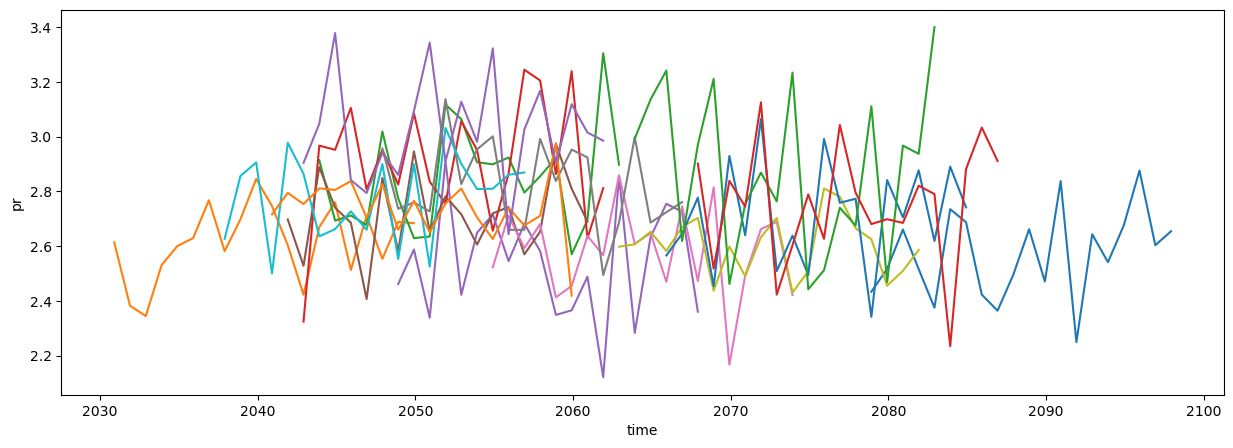

In [26]:
qmean = cmip6_ssp585_gwl.mean(["lat", "lon"]).resample(time="QS-DEC").mean()
plot = qmean["pr"].sel(time=qmean["pr"].time.dt.month==12).plot.line(x="time", add_legend=False, figsize=(15, 5))

Now we plot the map of the climatologies (mean of the period; 20-year means in this case). In the resulting plot, each panel represents a CMIP6 member (a model).

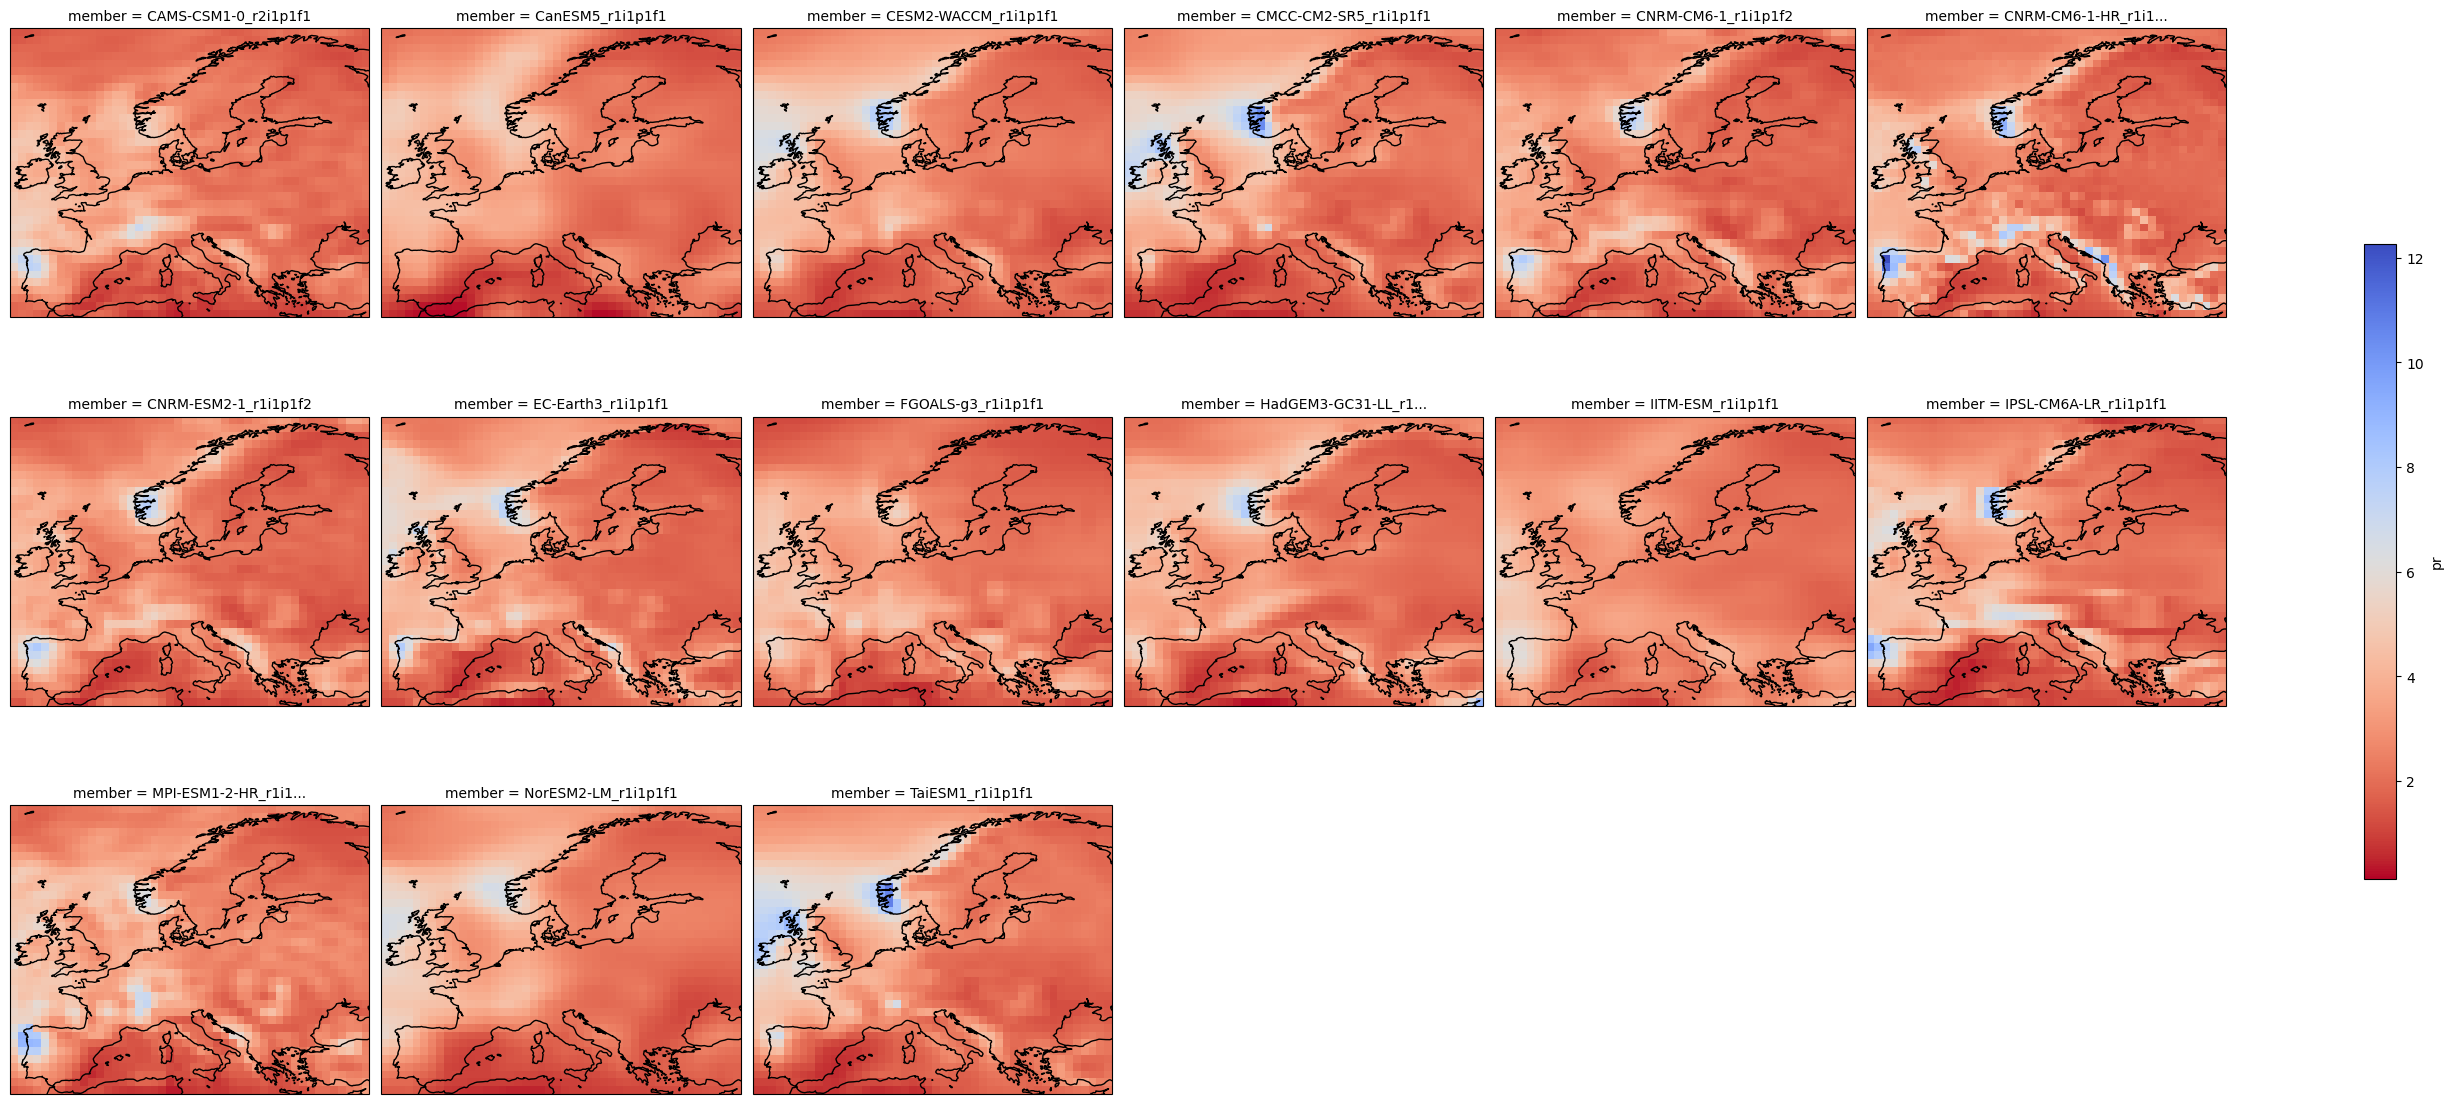

In [27]:
lats, lons = slice(35, 72), slice(-11, 35)

plot = cmip6_ssp585_gwl["pr"].mean("time").plot(
    x="lon", y="lat", col="member", col_wrap=6,
    # vmin=0, vmax=13,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

To get the climate change signal, we first need to load data from the historical scenario. To do this we repeat the filtering process to get the required dataset.

We are considering the pre-industrial period. In this case, the reference period is common to all models.

In [28]:
cmip6_historical_gwl = xarray.concat(
    [cmip6_historical.sel(
        member=model_run,
        time=slice("18501201", "19000201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

Now we can calculate the anomaly by computing the difference between both climatologies. We can easily do this using xarray functions.

In [29]:
delta = cmip6_ssp585_gwl["pr"].mean("time") - cmip6_historical_gwl["pr"].mean("time")

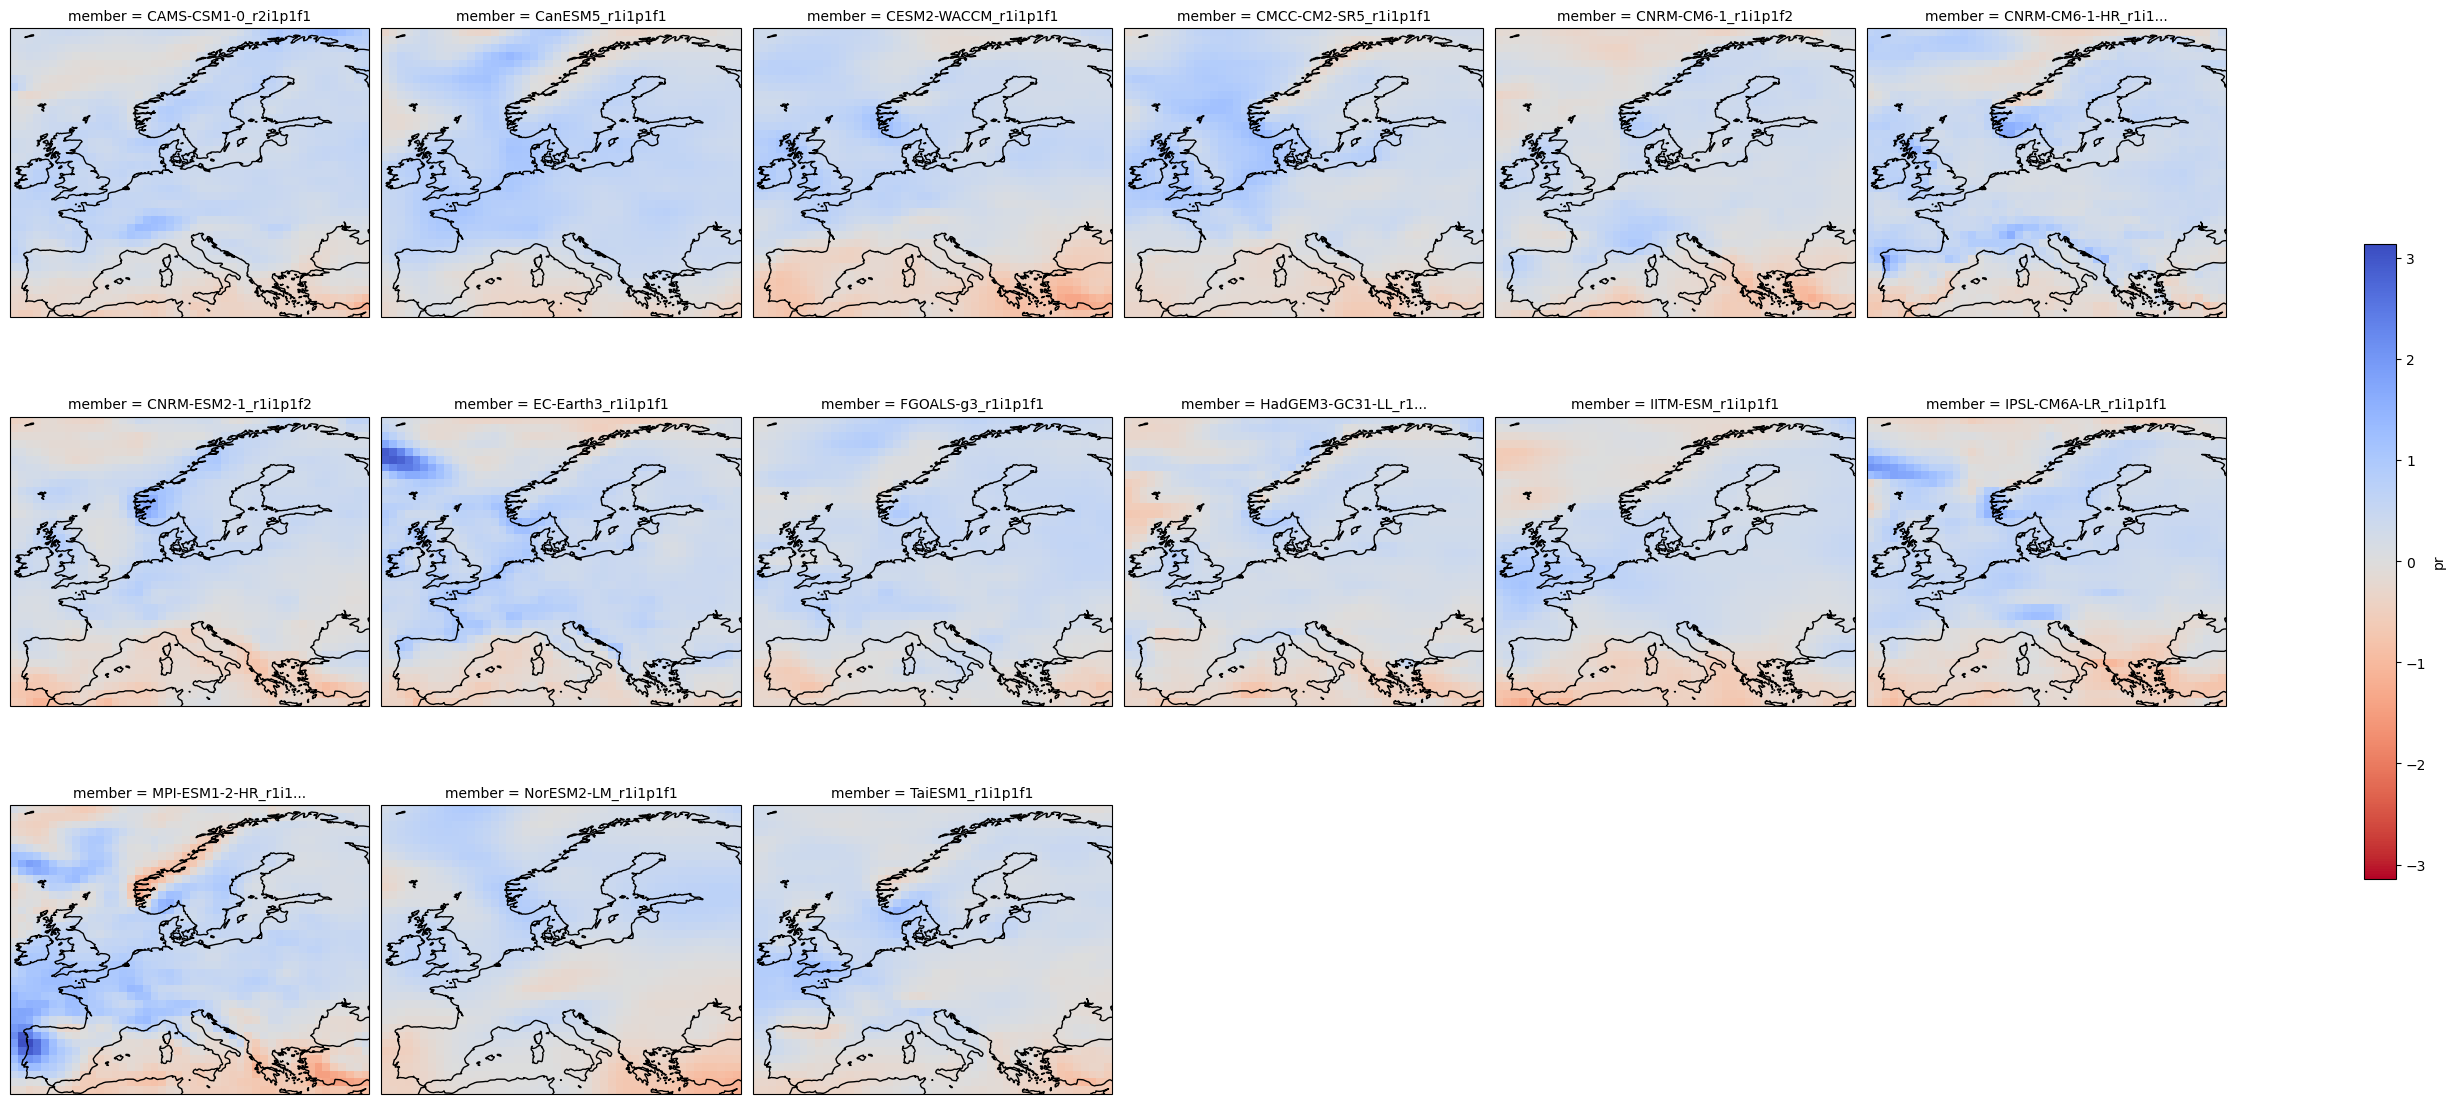

In [30]:
plot = delta.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

These maps represent the climate change signal as an absolute anomaly. We can calculate the relative anomaly as follows.

In [31]:
delta_rel = (delta / cmip6_historical_gwl["pr"].mean("time")) * 100

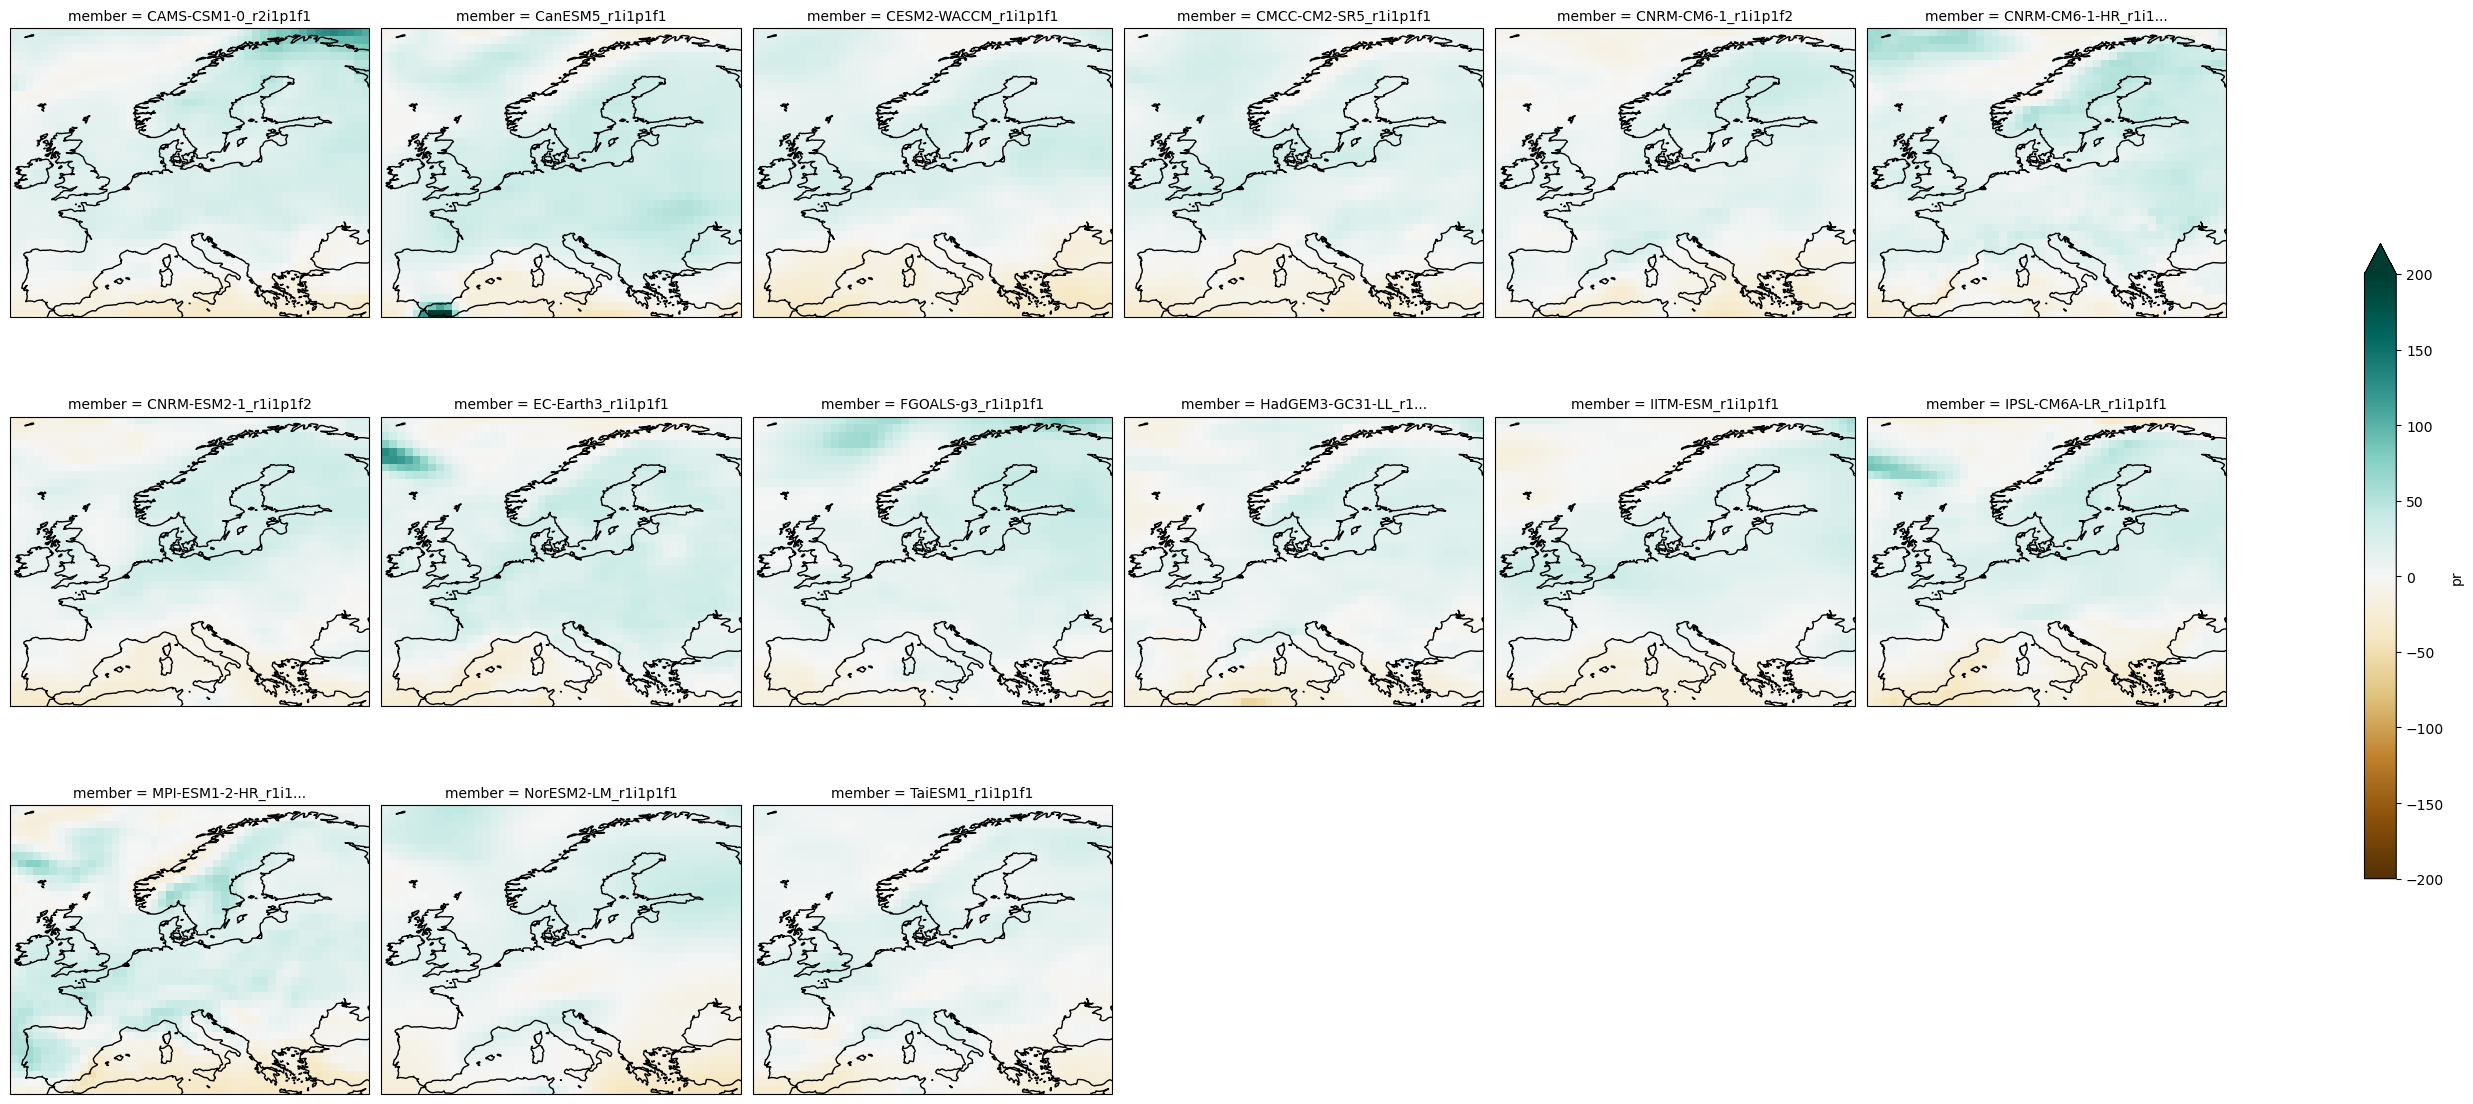

In [32]:
plot = delta_rel.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    vmax=200, vmin=-200,
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

We now calculate and plot the multi-model anomaly mean.

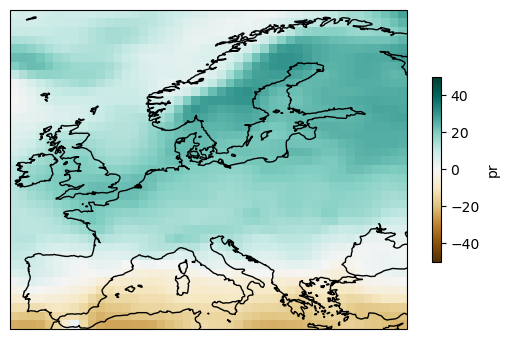

In [33]:
ens_mean = delta_rel.mean("member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

plot.axes.coastlines()

## 6. Uncertainty calculation and representation

We implement both the "simple" and "advanced" methods for uncertainty characterization defined in the IPCC Sixth Assessment Report. Please refer to the AR6 WGI Cross-Chapter Box Atlas 1 (Gutiérrez et al., 2021) for more information.

In [34]:
def model_agreement(da, axis, th = 80):
    nmembers, nlat, nlon = da.shape
    mask = np.array([
        (da[:,i,j] > 0).sum() > int(nmembers * th / 100)
        if da[:,i,j].mean() > 0
        else (da[:,i,j] < 0).sum() > int(nmembers * th / 100)
        for i in range(nlat)
        for j in range(nlon)]).reshape((nlat,nlon))
    
    return mask

def hatching(plot, mask, data):
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            lat, lon = data["lat"][i].item(), data["lon"][j].item()
            if mask[i,j]:
                plot.axes.plot([lon-.5,lon+.5],[lat+.5,lat-.5],'-',c="black", linewidth=.5)


Compute and display uncertainty via hatching using the "simple" method.

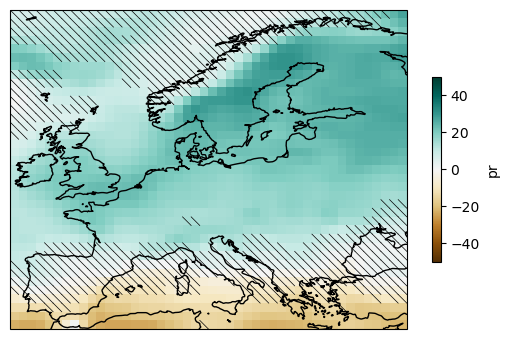

In [35]:
mask_simple = delta.reduce(model_agreement, "member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

hatching(plot, ~mask_simple, ens_mean)

plot.axes.coastlines()

plt.savefig("uncer-europe.svg", bbox_inches="tight")

We now display regional precipitation stripes for Europe. Each model represents a 20-year period centered on the point at which it reaches the GWL.

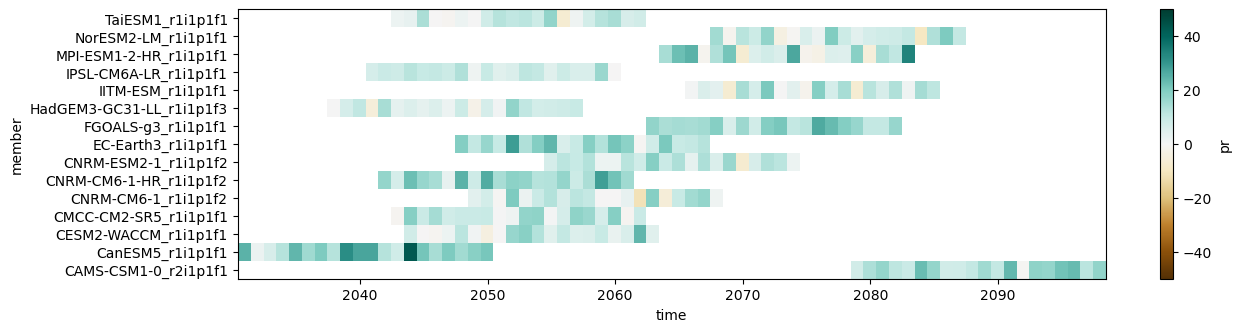

In [36]:
cmip6_ssp585_y = cmip6_ssp585_gwl["pr"].resample(time="QS-DEC").mean()
cmip6_ssp585_y = cmip6_ssp585_y.sel(time=cmip6_ssp585_y["time"].dt.month==12)

cmip6_hist_c = cmip6_historical_gwl["pr"].mean(["time"])

year_delta = cmip6_ssp585_y - cmip6_hist_c
year_delta_rel = year_delta / cmip6_hist_c * 100

regional_mean = year_delta_rel.mean(["lat", "lon"])

regional_mean.plot.imshow(
    figsize=(14,3.5),
    add_colorbar=True,
    cmap="BrBG",
    vmin=-50,vmax=50)
plt.savefig("regional-stripes-pr.pdf", bbox_inches="tight")

## 7. Pangeo

Until now, we have been working with the datasets provided by the ESGF Virtual Aggregation. We now carry out the same climate data analysis workflow by using the Analysis-Ready Cloud-Optimized datasets provided by [Pangeo](https://doi.org/10.1109/MCSE.2021.3059437).

In [37]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog["version"] = pangeo_catalog["version"].astype(str)
pangeo_catalog.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

Find the same model runs used within the ESGF Virtual Aggregation.

In [38]:
def find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, esgf_va_df, experiment):
    pangeo_model_runs = []
    
    for model, run in esgf_va_df.index.str.split("_"):
        version = atlas_ipcc_catalog.query(f"model == '{model}' & experiment == '{experiment}' & member == '{run}' & variable == 'pr'")["version"].iloc[0][1:]
        subset = pangeo_catalog.query(f"source_id == '{model}' & table_id == 'day' & variable_id == 'pr' & experiment_id == '{experiment}' & member_id == '{run}' & version == '{version}'").set_index(["source_id", "experiment_id", "version"]).drop(["variable_id"], axis=1)

        # descomentar cuando ejecute el notebook entero otra vez
        # if len(subset) == 0:
        #     raise ValueError(f"Missing model '{model}'")
        if model in ["ACCESS-CM2","ACCESS-ESM1-5"]:
            continue

        url = subset["zstore"].iloc[0]
        record = {"url": url, "model_run": model + "_" + model_runs[model]}
        pangeo_model_runs.append(record)

    return pd.DataFrame.from_records(pangeo_model_runs)

In [39]:
ssp585_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp585")
historical_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "historical")

In [40]:
df_pangeo = historical_model_runs_pangeo.set_index("model_run").join(ssp585_model_runs_pangeo.set_index("model_run"), how="inner", lsuffix="h", rsuffix="s").rename({"urlh": "historical", "urls": "ssp585"}, axis=1)
df_pangeo

historical  \
model_run                                                                     
CAMS-CSM1-0_r2i1p1f1      gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...   
CanESM5_r1i1p1f1          gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   
CESM2-WACCM_r1i1p1f1      gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...   
CMCC-CM2-SR5_r1i1p1f1     gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...   
CNRM-CM6-1_r1i1p1f2       gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...   
CNRM-CM6-1-HR_r1i1p1f2    gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-...   
CNRM-ESM2-1_r1i1p1f2      gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...   
EC-Earth3_r1i1p1f1        gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...   
FGOALS-g3_r1i1p1f1        gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/historical...   
HadGEM3-GC31-LL_r1i1p1f3  gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...   
IITM-ESM_r1i1p1f1         gs://cmip6/CMIP6/CMIP/CCCR-IITM/IITM-ESM/histo...   
IPSL-CM6A-LR_r1i1p1f1     gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
MPI-ESM1-2-HR_r1i1p1f1    gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...   
NorESM2-LM_r1i1p1f1       gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...   
TaiESM1_r1i1p1f1          gs://cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/historic...   

                                                                     ssp585  
model_run                                                                    
CAMS-CSM1-0_r2i1p1f1      gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...  
CanESM5_r1i1p1f1          gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...  
CESM2-WACCM_r1i1p1f1      gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...  
CMCC-CM2-SR5_r1i1p1f1     gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...  
CNRM-CM6-1_r1i1p1f2       gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...  
CNRM-CM6-1-HR_r1i1p1f2    gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...  
CNRM-ESM2-1_r1i1p1f2      gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...  
EC-Earth3_r1i1p1f1        gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...  
FGOALS-g3_r1i1p1f1        gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp...  
HadGEM3-GC31-LL_r1i1p1f3  gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31...  
IITM-ESM_r1i1p1f1         gs://cmip6/CMIP6/ScenarioMIP/CCCR-IITM/IITM-ES...  
IPSL-CM6A-LR_r1i1p1f1     gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...  
MPI-ESM1-2-HR_r1i1p1f1    gs://cmip6/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-H...  
NorESM2-LM_r1i1p1f1       gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ss...  
TaiESM1_r1i1p1f1          gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...

Load the datasets.

In [41]:
def load_datasets_pangeo(locations, members, experiment):
    dss = []
    for location in locations:
        model = location.split("/")[6]

        ds = xarray.open_zarr(
            location,
            drop_variables=["time_bnds", "lat_bnds", "lon_bnds"])

        if experiment == "ssp585":
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

In [42]:
historical_dss_pangeo = load_datasets_pangeo(df_pangeo["historical"], model_runs, "historical")
ssp585_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp585"], model_runs, "ssp585")

/tmp/ipykernel_759538/2009675485.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_zarr(


Print size of the datasets:

In [43]:
for ds in historical_dss_pangeo:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

11770.51 MB
1882.03 MB
12703.92 MB
12703.71 MB
7533.12 MB
59588.20 MB
7533.12 MB
30132.50 MB
3348.36 MB
6264.84 MB
4149.17 MB
4733.95 MB
16949.53 MB
3175.93 MB
12703.71 MB


In [44]:
for ds in ssp585_dss_pangeo:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
1724.30 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


Implement the function that will subset and fetch the data from the cloud repository.

In [45]:
def efficient_retrieval_and_compute_pangeo(ds):
    lats, lons = slice(35, 72), slice(-11, 35) # Europe in (-180, 180)

    # handle Europe being split when using (0, 360)
    if ds["lon"].min().item() >= 0:
        spatial = ds.sel(
            time=ds.time.dt.month.isin([12,1,2]),
            lon=(ds["lon"] <= 36) | (ds["lon"] >= 348),
            lat=slice(35, 72)).load()
    else:
        spatial = ds.sel(time=ds.time.dt.month.isin([12,1,2]), lon=lons, lat=lats).load()

    winter = spatial.resample({"time": "MS"}).sum()
    winter = winter.assign_coords(lon=((winter["lon"] + 180) % 360) - 180).sortby("lon")

    return winter

Load the data.

In [46]:
%%time

historical_dss_subset_pangeo = [efficient_retrieval_and_compute_pangeo(ds) for ds in historical_dss_pangeo]

CPU times: user 22.9 s, sys: 11.1 s, total: 34 s
Wall time: 24min 13s


In [47]:
%%time

ssp585_dss_subset_pangeo = [efficient_retrieval_and_compute_pangeo(ds) for ds in ssp585_dss_pangeo]

CPU times: user 12.9 s, sys: 5.69 s, total: 18.6 s
Wall time: 15min 14s


Look at the sizes of the subsets.

In [48]:
for ds in historical_dss_subset_pangeo:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

10.72 MB
1.67 MB
11.20 MB
11.19 MB
6.68 MB
54.22 MB
6.68 MB
27.62 MB
3.44 MB
5.66 MB
3.93 MB
4.16 MB
15.41 MB
2.87 MB
11.19 MB


In [49]:
for ds in ssp585_dss_subset_pangeo:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

5.52 MB
0.87 MB
5.83 MB
5.83 MB
3.48 MB
28.26 MB
3.48 MB
14.40 MB
1.77 MB
2.95 MB
2.02 MB
2.17 MB
8.03 MB
1.50 MB
5.83 MB


Interpolate to a common grid.

In [50]:
ssp585_dss_subset_interp_pangeo = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in ssp585_dss_subset_pangeo]

historical_dss_subset_interp_pangeo = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in historical_dss_subset_pangeo]

for ds in ssp585_dss_subset_interp_pangeo:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

for ds in historical_dss_subset_interp_pangeo:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

In [51]:
cmip6_ssp585_pangeo = xarray.concat(
    ssp585_dss_subset_interp_pangeo,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in ssp585_dss_subset_interp_pangeo]))

cmip6_historical_pangeo = xarray.concat(
    historical_dss_subset_interp_pangeo,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in historical_dss_subset_interp_pangeo]))

Reproduce the figures.

In [52]:
cmip6_ssp585_gwl = xarray.concat(
    [cmip6_ssp585_pangeo.sel(
        member=model_run,
        time=slice(f"{year-10}1201", f"{year+10}0201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

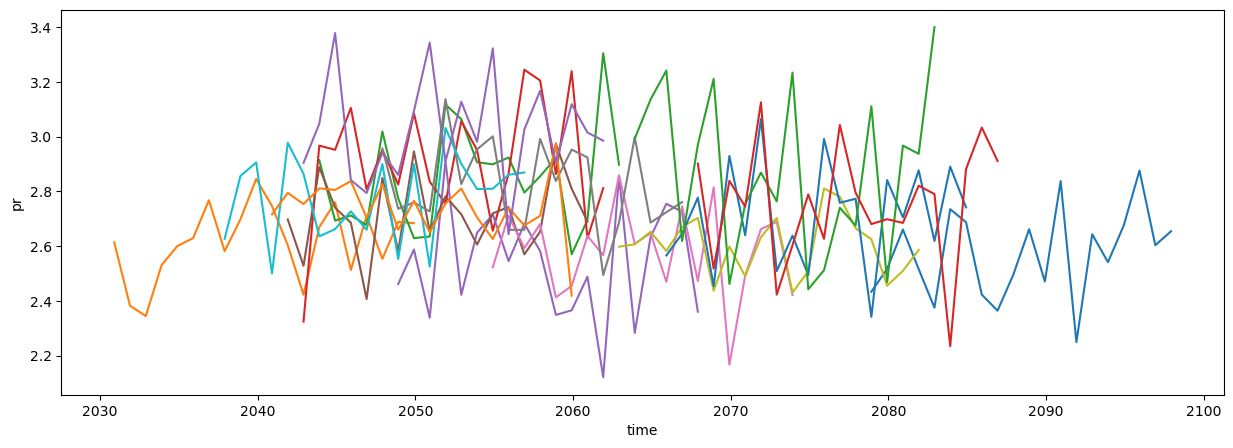

In [53]:
qmean = cmip6_ssp585_gwl.mean(["lat", "lon"]).resample(time="QS-DEC").mean()
plot = qmean["pr"].sel(time=qmean["pr"].time.dt.month==12).plot.line(x="time", add_legend=False, figsize=(15, 5))

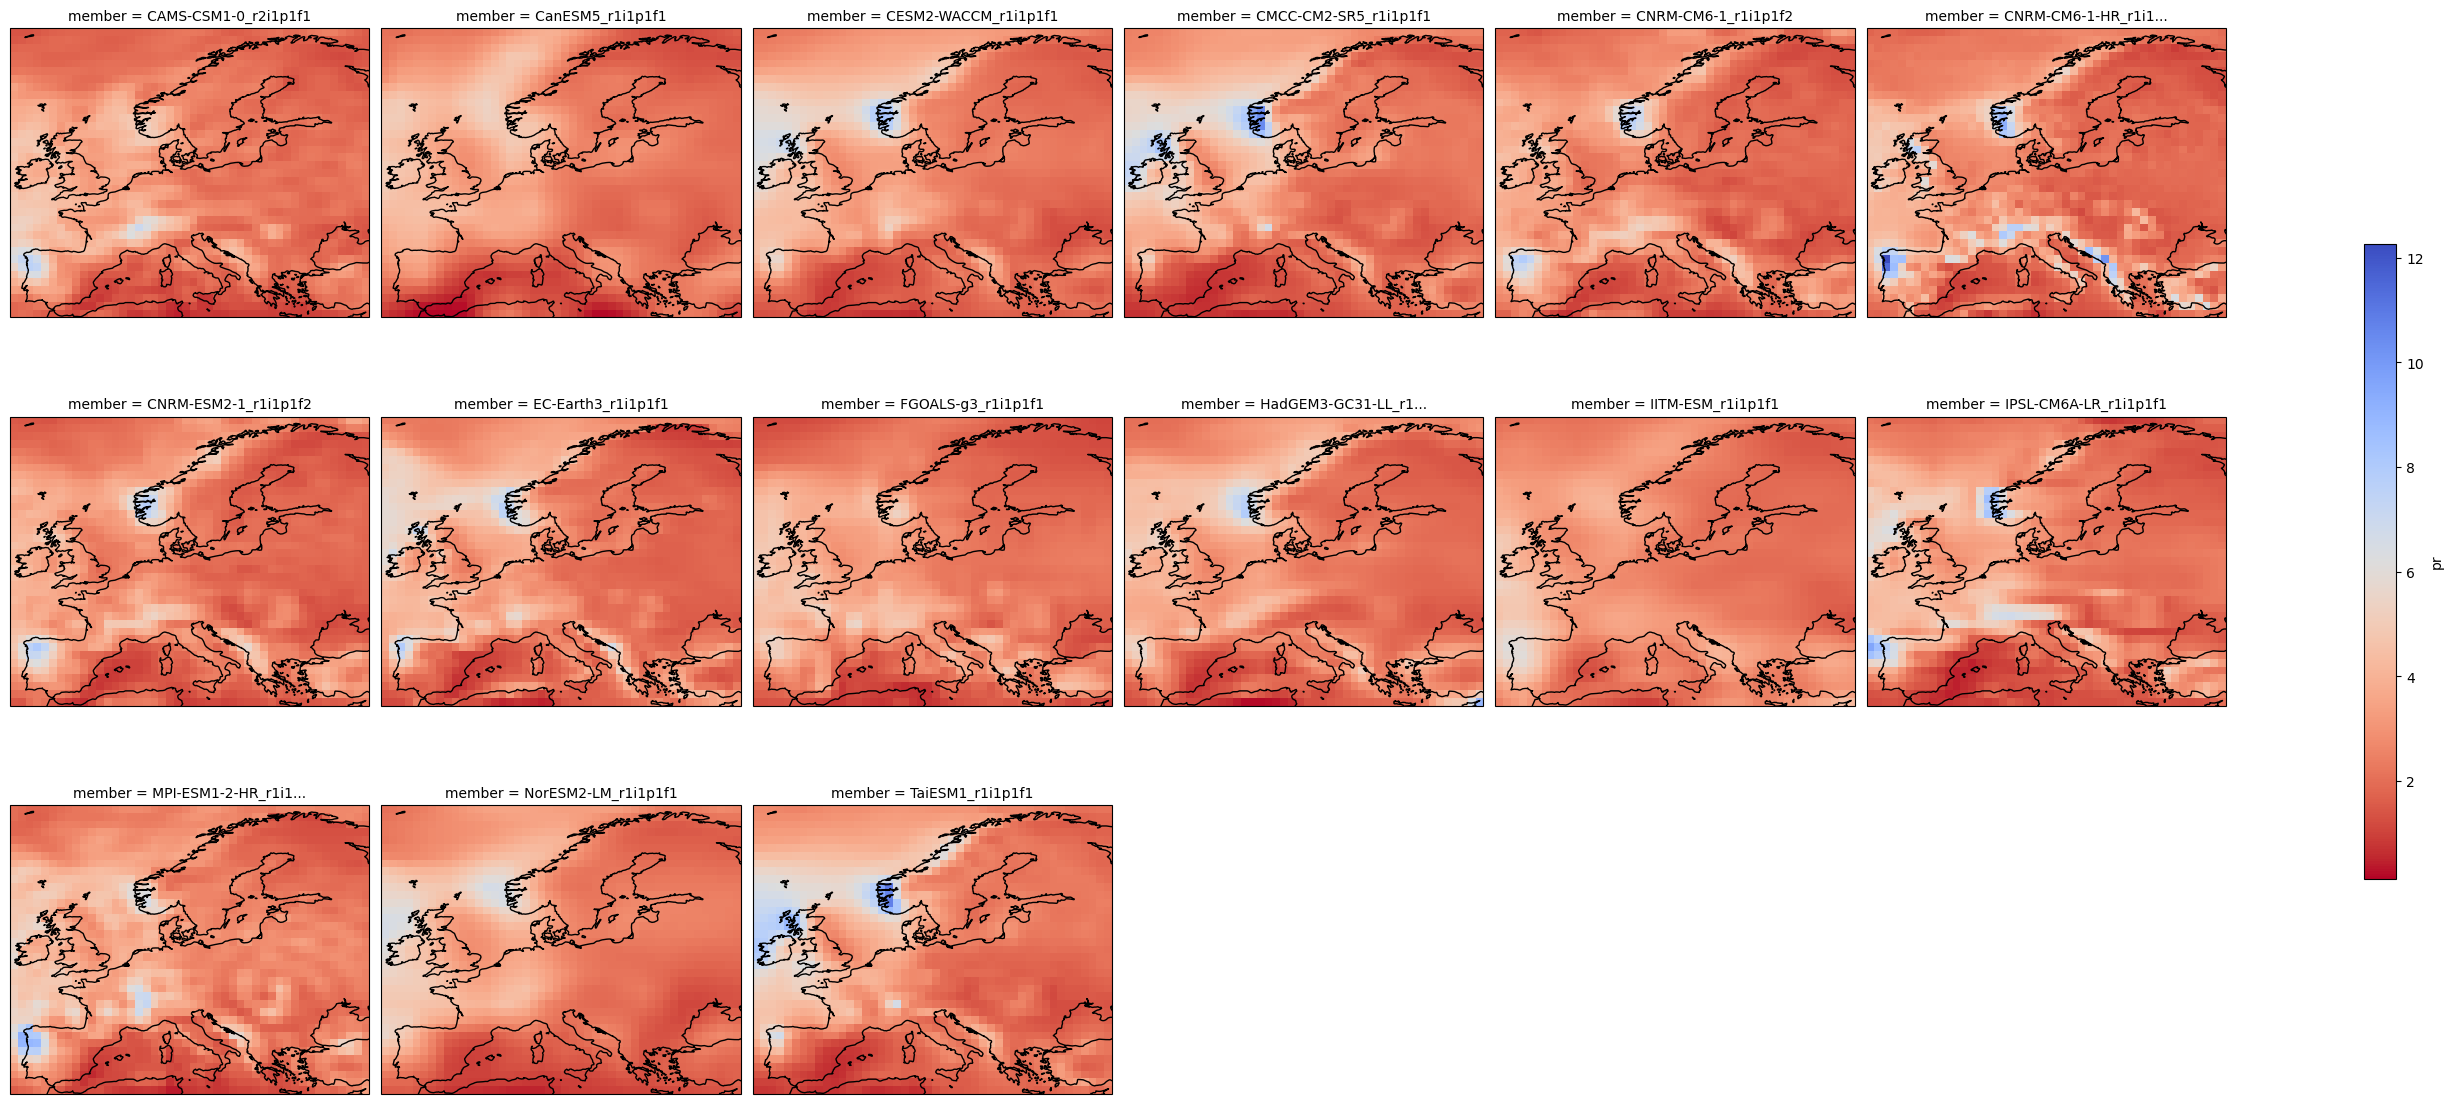

In [54]:
lats, lons = slice(35, 72), slice(-11, 35)

plot = cmip6_ssp585_gwl["pr"].mean("time").plot(
    x="lon", y="lat", col="member", col_wrap=6,
    # vmin=0, vmax=13,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

In [55]:
cmip6_historical_gwl = xarray.concat(
    [cmip6_historical_pangeo.sel(
        member=model_run,
        time=slice("18501201", "19000201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

In [56]:
delta = cmip6_ssp585_gwl["pr"].mean("time") - cmip6_historical_gwl["pr"].mean("time")

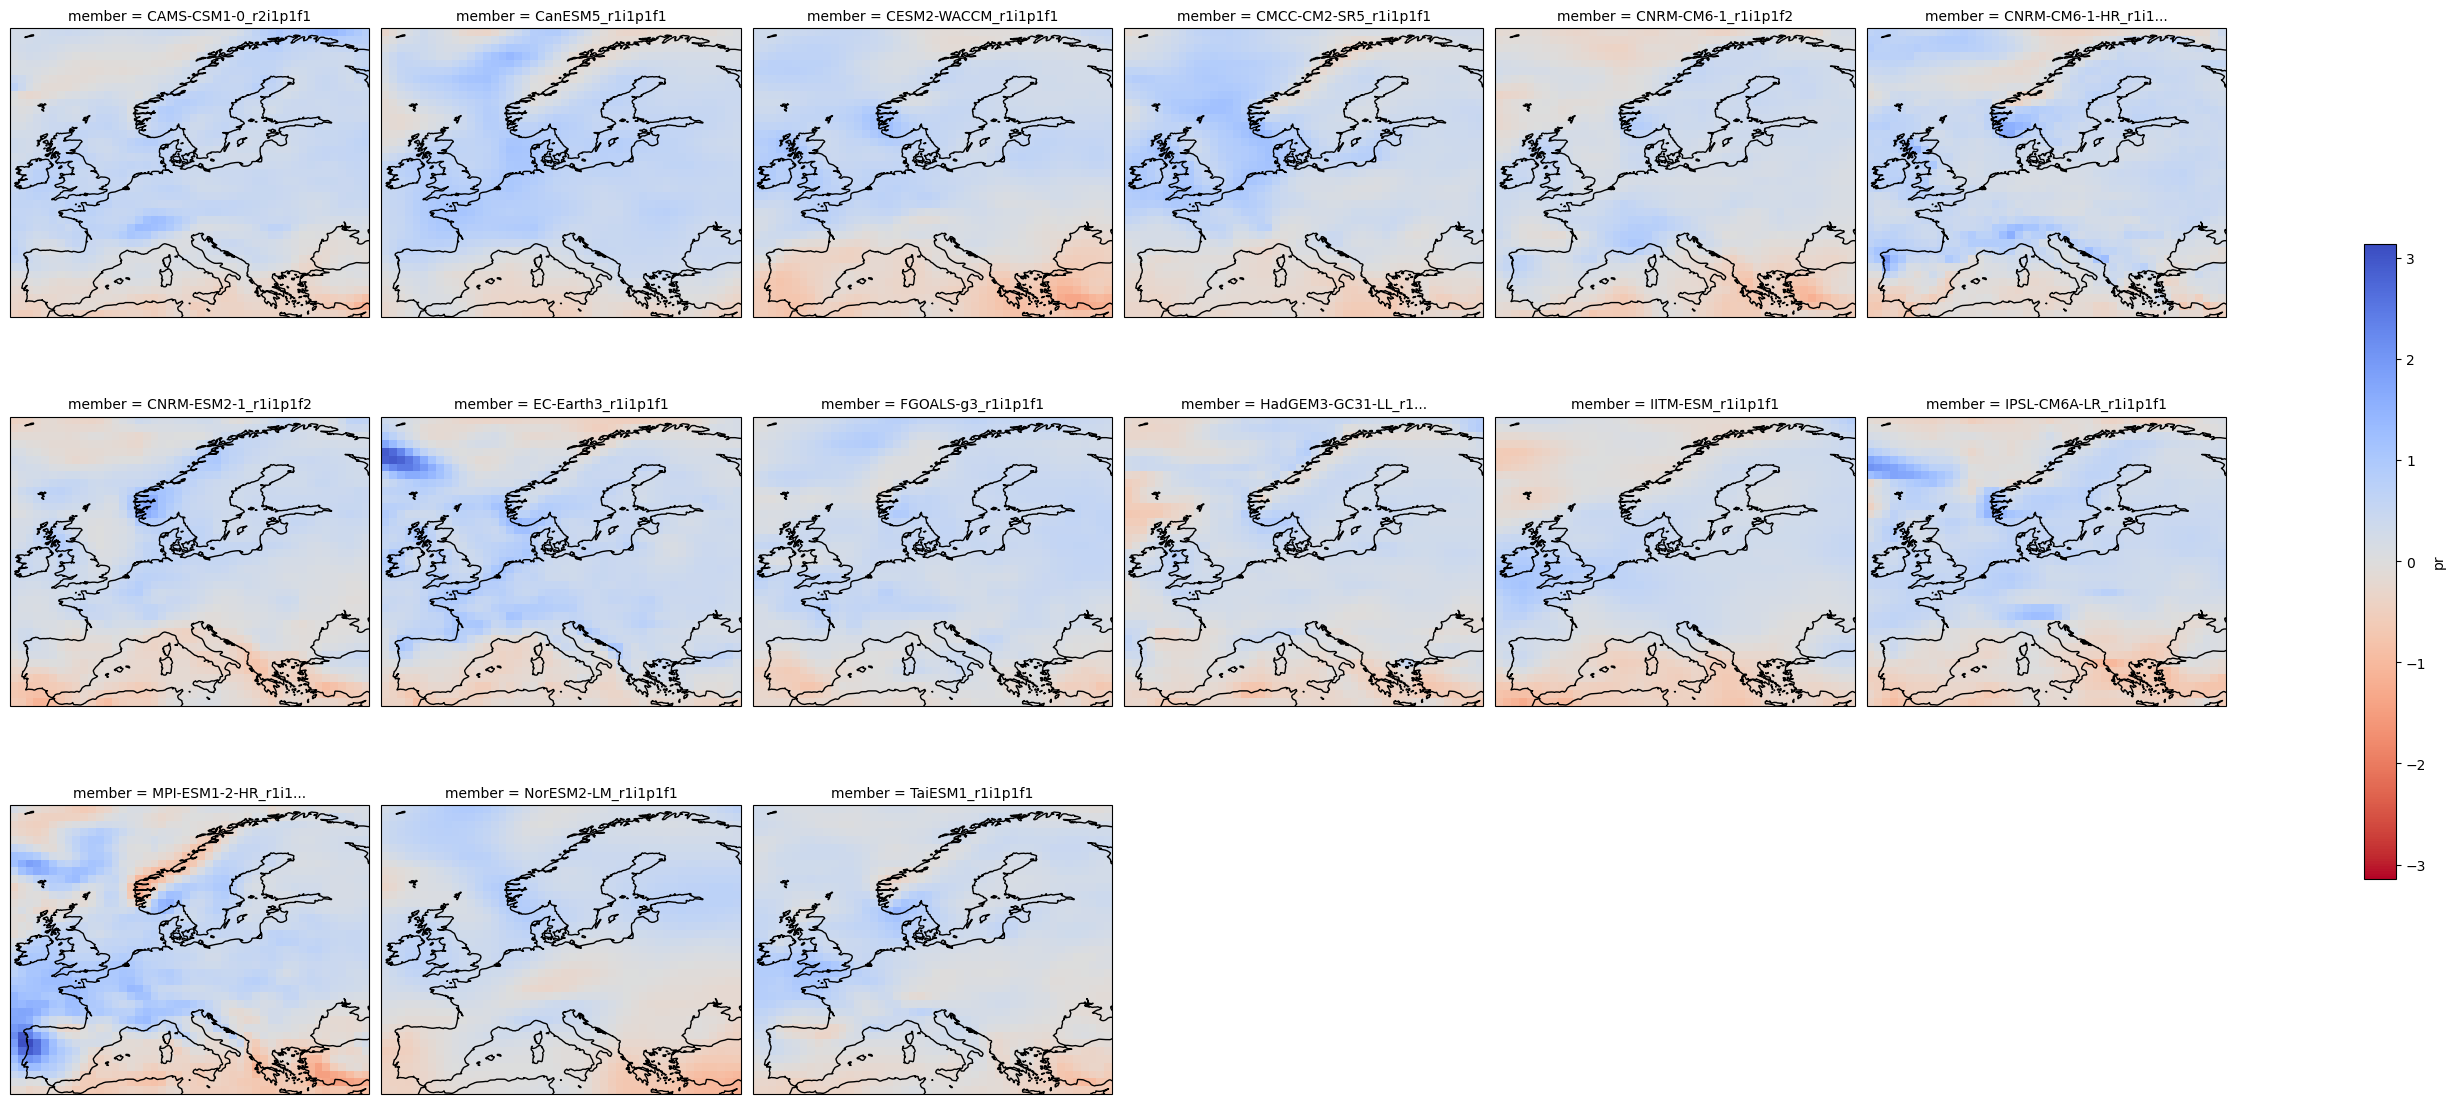

In [57]:
plot = delta.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

In [58]:
delta_rel = (delta / cmip6_historical_gwl["pr"].mean("time")) * 100

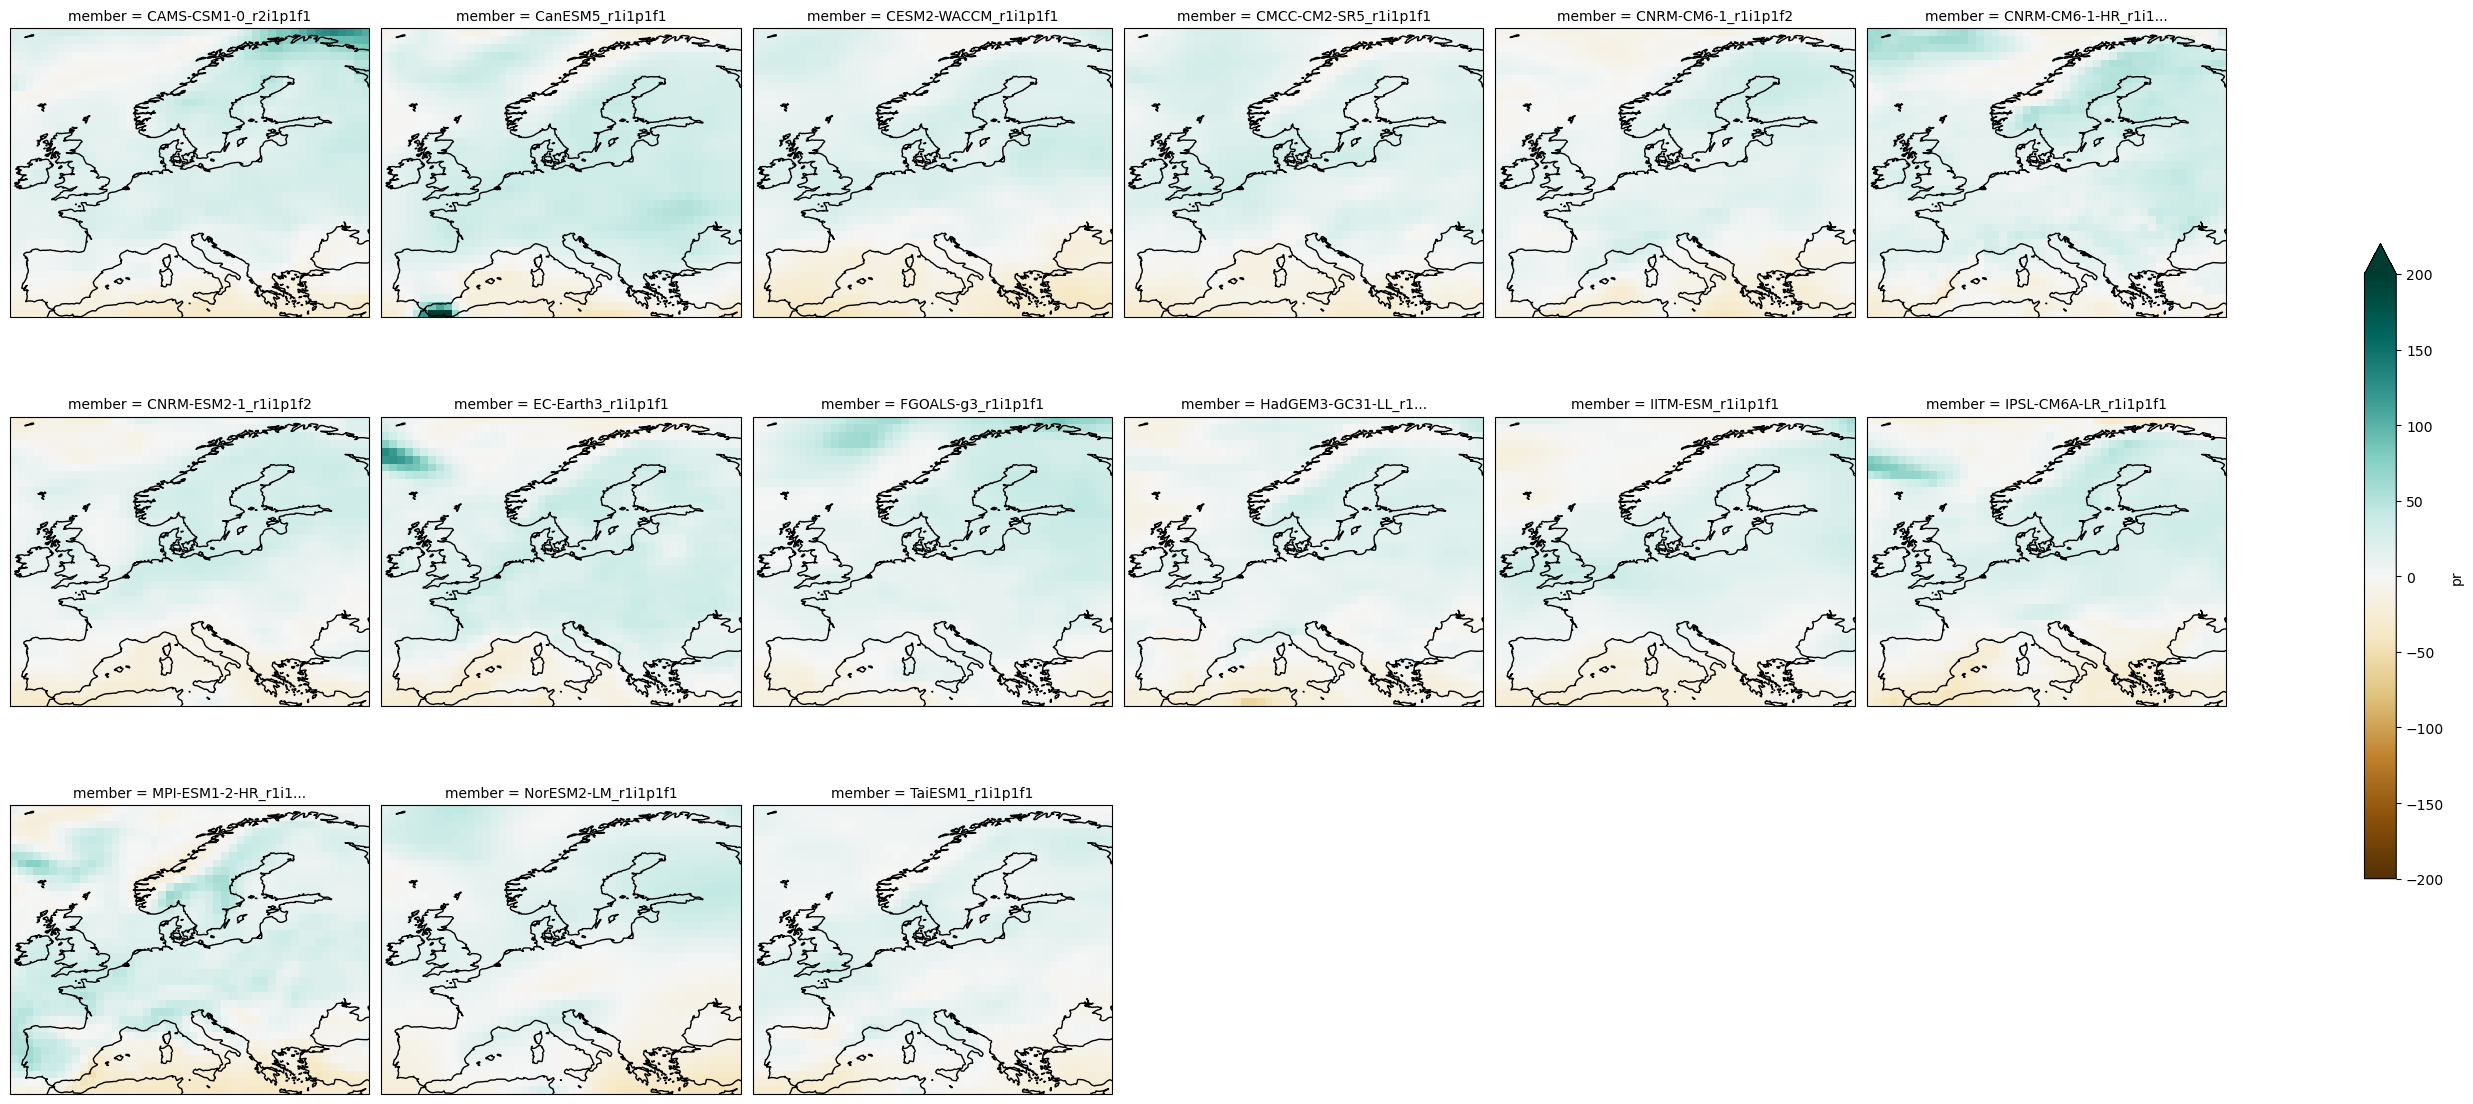

In [59]:
plot = delta_rel.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    vmax=200, vmin=-200,
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

Ensemble mean.

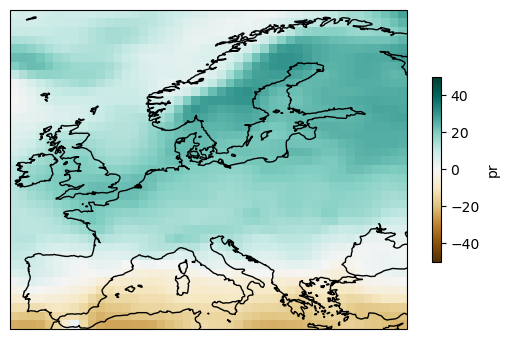

In [60]:
ens_mean = delta_rel.mean("member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

plot.axes.coastlines()

Model agreement.

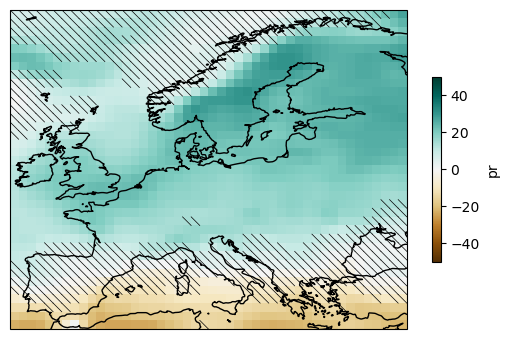

In [61]:
mask_simple = delta.reduce(model_agreement, "member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

hatching(plot, ~mask_simple, ens_mean)

plot.axes.coastlines()

plt.savefig("uncer-europe.svg", bbox_inches="tight")

Regional stripes.

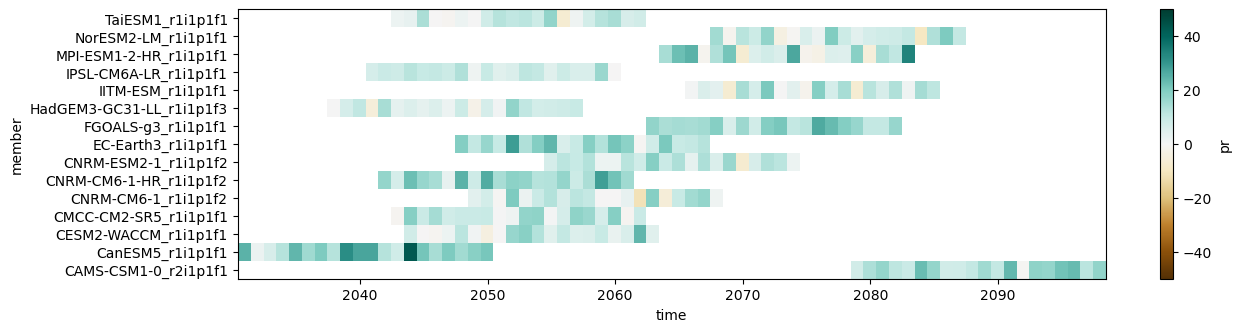

In [63]:
cmip6_ssp585_y = cmip6_ssp585_gwl["pr"].resample(time="QS-DEC").mean()
cmip6_ssp585_y = cmip6_ssp585_y.sel(time=cmip6_ssp585_y["time"].dt.month==12)

cmip6_hist_c = cmip6_historical_gwl["pr"].mean(["time"])

year_delta = cmip6_ssp585_y - cmip6_hist_c
year_delta_rel = year_delta / cmip6_hist_c * 100

regional_mean = year_delta_rel.mean(["lat", "lon"])

regional_mean.plot.imshow(
    figsize=(14,3.5),
    add_colorbar=True,
    cmap="BrBG",
    vmin=-50,vmax=50)
plt.savefig("regional-stripes-pr.pdf", bbox_inches="tight")

# Annex I

This functions optimizes dask chunking for efficient retrieval. However, it is even more expensive than loading unnecessary data (currently, historical takes ~13 min and with this function it takes ~23 min).

In [ ]:
def efficient_retrieval_and_compute(ds):
    lats, lons = slice(35, 72), slice(-11, 35) # Europe in (-180, 180)

    # Step 1: Map values to group labels
    grouped = ((ds["time"].dt.month.values >= 3) & (ds["time"].dt.month.values < 12)).astype(int)  # winter months 12, 1, 2
    change_indices = np.where(np.diff(grouped) != 0)[0] + 1 # Step 2: Find where the group changes
    segment_edges = np.concatenate(([0], change_indices, [len(ds["time"].dt.month.values)])) # Step 3: Segment edges
    counts = tuple(np.diff(segment_edges)) # Step 4: Lengths of each group run

    # handle Europe being split when using (0, 360)
    if ds["lon"].min().item() >= 0:
        left = ds.chunk({"time": counts}).sel(time=ds.time.dt.month.isin([12,1,2]), lon=slice(0, 36), lat=lats)
        right = ds.chunk({"time": counts}).sel(time=ds.time.dt.month.isin([12,1,2]), lon=slice(348, 360), lat=lats)

        spatial = xarray.concat([left, right], dim="lon")
    else:
        spatial = ds.sel(time=ds.time.dt.month.isin([12,1,2]), lon=lons, lat=lats)

    winter = spatial.resample({"time": "MS"}).sum().load()
    winter = winter.assign_coords(lon=((winter["lon"] + 180) % 360) - 180).sortby("lon")

    return winter